In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
%matplotlib inline

In [2]:
from zipfile import ZipFile
import geopandas as gpd
from shapely.geometry import Point

In [3]:
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
ZIP_PATH = os.path.join('data', '2016-us-election.zip') 
with ZipFile(ZIP_PATH) as zip_file:
    with zip_file.open('primary_results.csv') as my_zipped_csv:
        primary_df = pd.read_csv(my_zipped_csv)

primary_df.head()

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes
0,Alabama,AL,Autauga,1001.0,Democrat,Bernie Sanders,544,0.182
1,Alabama,AL,Autauga,1001.0,Democrat,Hillary Clinton,2387,0.800
2,Alabama,AL,Baldwin,1003.0,Democrat,Bernie Sanders,2694,0.329
3,Alabama,AL,Baldwin,1003.0,Democrat,Hillary Clinton,5290,0.647
4,Alabama,AL,Barbour,1005.0,Democrat,Bernie Sanders,222,0.078


In [5]:
SHP_PATH = os.path.join('data', 'county_shapefiles', '5m')
coord_system = {'init': 'epsg:4326'}
tracts = gpd.read_file(SHP_PATH).to_crs(coord_system)


(-178, -55)

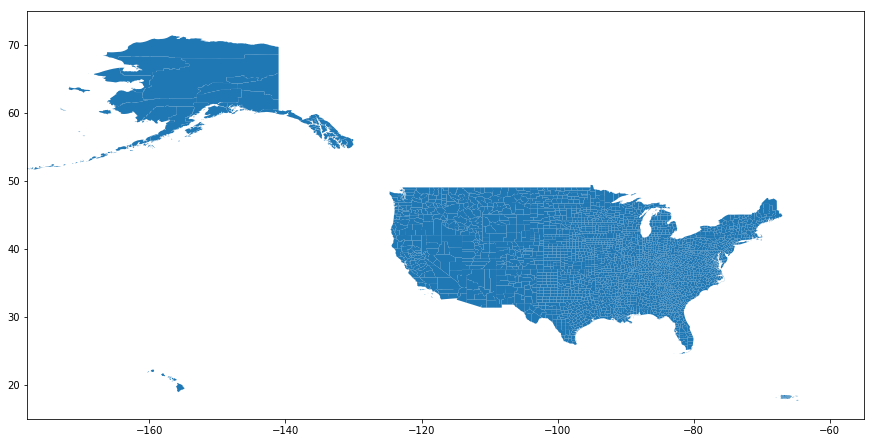

In [6]:
ax = tracts.plot(figsize=(15,10))
ax.set_ylim([15, 75])
ax.set_xlim([-178, -55])

In [7]:
tracts.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,059,00161555,0500000US01059,01059,Franklin,06,1641580723,32904833,"POLYGON Z ((-88.16591 34.380926 0, -88.165634 ..."
1,13,111,00351094,0500000US13111,13111,Fannin,06,1002370118,13560697,"POLYGON Z ((-84.621483 34.988329 0, -84.509885..."
2,19,109,00465243,0500000US19109,19109,Kossuth,06,2519332669,4154722,"POLYGON Z ((-94.44313699999999 43.255014 0, -9..."
3,40,115,01101845,0500000US40115,40115,Ottawa,06,1219467406,35708892,"POLYGON Z ((-95.03412299999999 36.994225 0, -9..."
4,42,115,01213688,0500000US42115,42115,Susquehanna,06,2132881515,22356541,"POLYGON Z ((-76.13120099999999 41.998954 0, -7..."


In [8]:
primary_df.head()

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes
0,Alabama,AL,Autauga,1001.0,Democrat,Bernie Sanders,544,0.182
1,Alabama,AL,Autauga,1001.0,Democrat,Hillary Clinton,2387,0.800
2,Alabama,AL,Baldwin,1003.0,Democrat,Bernie Sanders,2694,0.329
3,Alabama,AL,Baldwin,1003.0,Democrat,Hillary Clinton,5290,0.647
4,Alabama,AL,Barbour,1005.0,Democrat,Bernie Sanders,222,0.078


In [9]:
primary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24611 entries, 0 to 24610
Data columns (total 8 columns):
state                 24611 non-null object
state_abbreviation    24611 non-null object
county                24611 non-null object
fips                  24511 non-null float64
party                 24611 non-null object
candidate             24611 non-null object
votes                 24611 non-null int64
fraction_votes        24611 non-null float64
dtypes: float64(2), int64(1), object(5)
memory usage: 1.5+ MB


In [10]:
primary_nn = primary_df[primary_df['fips'].notnull()].copy()

In [11]:
primary_nn['fips'] = primary_nn['fips'].astype(int)
primary_nn['fips'] = primary_nn['fips'].astype(str)

In [12]:
primary_nn['fips'].head()

0    1001
1    1001
2    1003
3    1003
4    1005
Name: fips, dtype: object

In [16]:
def fips_fixer(row):
    while (len(row['fips']) < 5):
        row['fips'] = '0' + row['fips']
    return row['fips']

In [17]:
primary_nn['fixed_fips'] = primary_nn.apply(fips_fixer, axis=1)

In [18]:
primary_nn.head()

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes,fixed_fips
0,Alabama,AL,Autauga,1001,Democrat,Bernie Sanders,544,0.182,01001
1,Alabama,AL,Autauga,1001,Democrat,Hillary Clinton,2387,0.800,01001
2,Alabama,AL,Baldwin,1003,Democrat,Bernie Sanders,2694,0.329,01003
3,Alabama,AL,Baldwin,1003,Democrat,Hillary Clinton,5290,0.647,01003
4,Alabama,AL,Barbour,1005,Democrat,Bernie Sanders,222,0.078,01005


In [25]:
dem_df = primary_nn[primary_nn['party'] == 'Democrat']
rep_df = primary_nn[primary_nn['party'] == 'Republican']

In [47]:
dem_primary = dem_df.pivot(index='fixed_fips', columns='candidate', values='fraction_votes')
rep_primary = rep_df.pivot(index='fixed_fips', columns='candidate', values='fraction_votes')

In [49]:
dem_primary_shp = pd.merge(left=tracts, right=dem_primary, left_on='GEOID', right_index=True)
rep_primary_shp = pd.merge(left=tracts, right=rep_primary, left_on='GEOID', right_index=True)

In [50]:
dem_primary_shp.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,No Preference,Uncommitted,Bernie Sanders,Hillary Clinton,Martin O'Malley
0,01,059,00161555,0500000US01059,01059,Franklin,06,1641580723,32904833,"POLYGON Z ((-88.16591 34.380926 0, -88.165634 ...",NaN,NaN,0.301,0.484,NaN
1,13,111,00351094,0500000US13111,13111,Fannin,06,1002370118,13560697,"POLYGON Z ((-84.621483 34.988329 0, -84.509885...",NaN,NaN,0.391,0.599,NaN
2,19,109,00465243,0500000US19109,19109,Kossuth,06,2519332669,4154722,"POLYGON Z ((-94.44313699999999 43.255014 0, -9...",NaN,0.01,0.360,0.608,0.022
3,40,115,01101845,0500000US40115,40115,Ottawa,06,1219467406,35708892,"POLYGON Z ((-95.03412299999999 36.994225 0, -9...",NaN,NaN,0.501,0.393,NaN
4,42,115,01213688,0500000US42115,42115,Susquehanna,06,2132881515,22356541,"POLYGON Z ((-76.13120099999999 41.998954 0, -7...",NaN,NaN,0.482,0.505,NaN


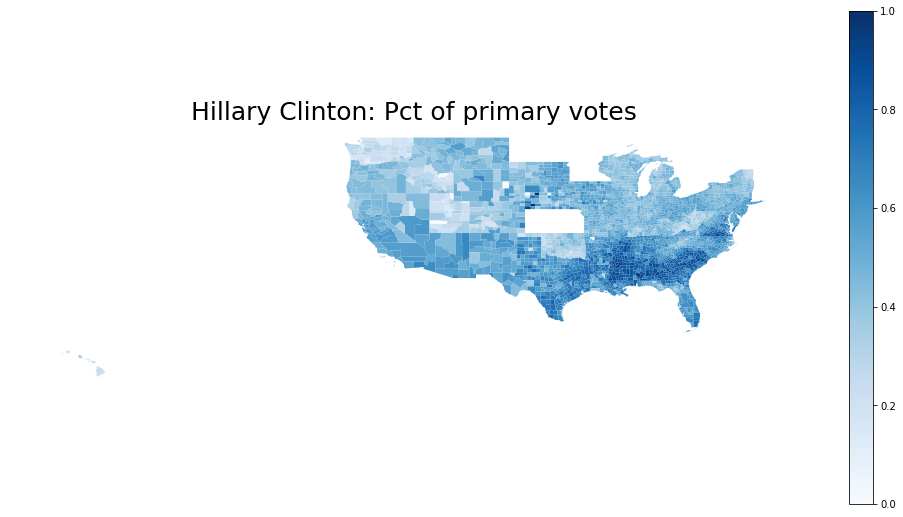

In [45]:
fig, ax = plt.subplots(figsize=(14,14))
my_cmap='Blues'
col_ = 'Hillary Clinton'
df = dem_primary_shp
vmin = df[col_].min()
vmax = df[col_].max()

_ = df.plot(column=col_, 
                      cmap=my_cmap, ax=ax)
_ = ax.axis('off')
_ = ax.set_title("Hillary Clinton: Pct of primary votes", 
                 fontdict={'fontsize': '25', 'fontweight' : '3'})
# _ = ax.annotate('Source: American Community Survey, 2015',
#                 xy=(0.1, .1), xycoords='figure fraction',
#                 horizontalalignment='left', verticalalignment='top',
#                 fontsize=10, color='#555555')
# ax.set_xlim([-130, -55])
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, shrink=0.5)
plt.tight_layout()

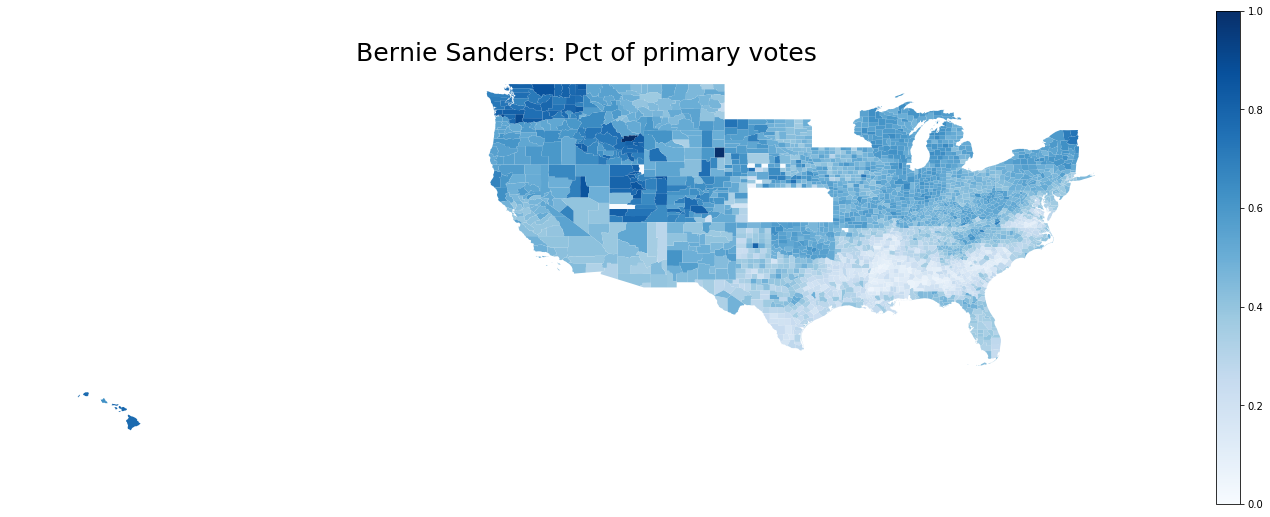

In [59]:
fig, ax = plt.subplots(figsize=(20,14))
my_cmap='Blues'
col_ = 'Bernie Sanders'
df = dem_primary_shp
vmin = df[col_].min()
vmax = df[col_].max()

_ = df.plot(column=col_, 
                      cmap=my_cmap, ax=ax)
_ = ax.axis('off')
_ = ax.set_title("Bernie Sanders: Pct of primary votes", 
                 fontdict={'fontsize': '25', 'fontweight' : '3'})
# _ = ax.annotate('Source: American Community Survey, 2015',
#                 xy=(0.1, .1), xycoords='figure fraction',
#                 horizontalalignment='left', verticalalignment='top',
#                 fontsize=10, color='#555555')
# ax.set_xlim([-130, -55])
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, shrink=0.5)
plt.tight_layout()

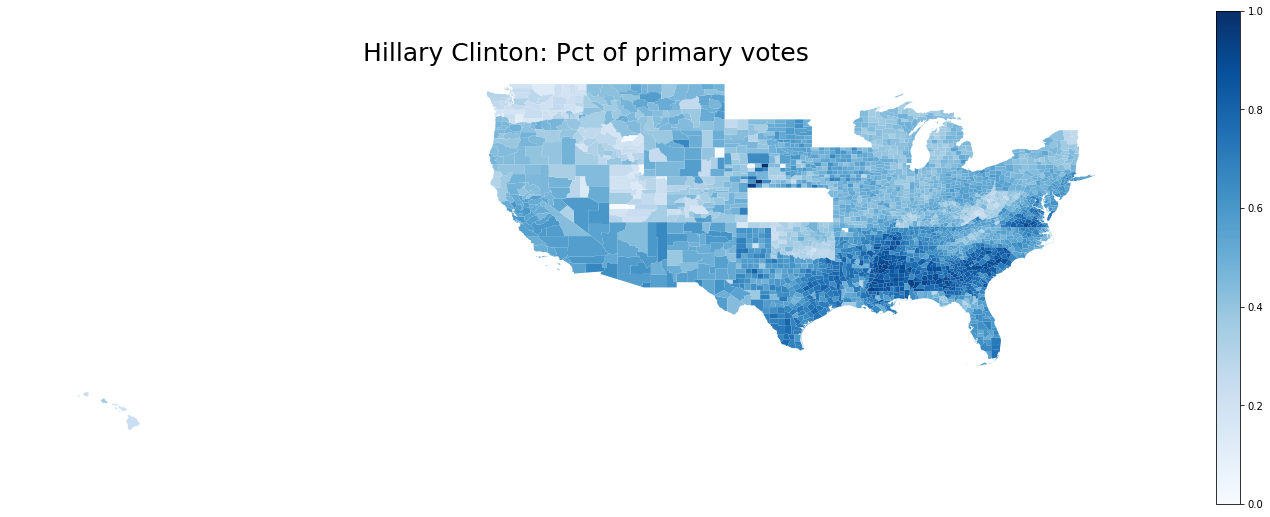

In [60]:
fig, ax = plt.subplots(figsize=(20,14))
my_cmap='Blues'
col_ = 'Hillary Clinton'
df = dem_primary_shp
vmin = df[col_].min()
vmax = df[col_].max()

_ = df.plot(column=col_, 
                      cmap=my_cmap, ax=ax)
_ = ax.axis('off')
_ = ax.set_title("Hillary Clinton: Pct of primary votes", 
                 fontdict={'fontsize': '25', 'fontweight' : '3'})
# _ = ax.annotate('Source: American Community Survey, 2015',
#                 xy=(0.1, .1), xycoords='figure fraction',
#                 horizontalalignment='left', verticalalignment='top',
#                 fontsize=10, color='#555555')
# ax.set_xlim([-130, -55])
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, shrink=0.5)
plt.tight_layout()

In [57]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

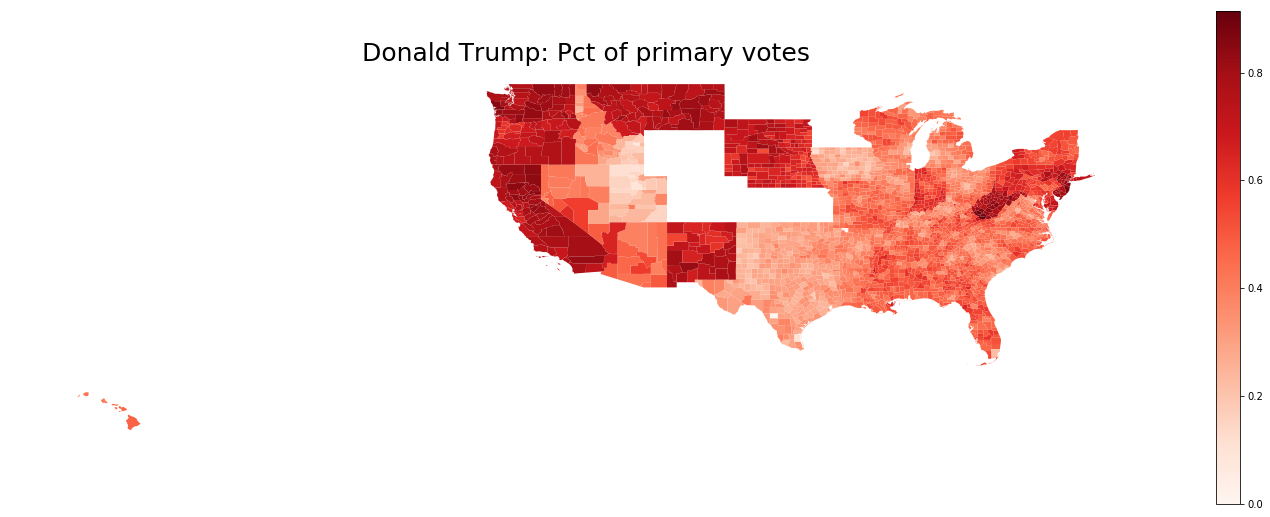

In [58]:
fig, ax = plt.subplots(figsize=(20,14))
my_cmap='Reds'
col_ = 'Donald Trump'
df = rep_primary_shp
vmin = df[col_].min()
vmax = df[col_].max()

_ = df.plot(column=col_, 
                      cmap=my_cmap, ax=ax)
_ = ax.axis('off')
_ = ax.set_title("{}: Pct of primary votes".format(col_), 
                 fontdict={'fontsize': '25', 'fontweight' : '3'})
# _ = ax.annotate('Source: American Community Survey, 2015',
#                 xy=(0.1, .1), xycoords='figure fraction',
#                 horizontalalignment='left', verticalalignment='top',
#                 fontsize=10, color='#555555')
# ax.set_xlim([-130, -55])
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, shrink=0.5)
plt.tight_layout()